# Deep Learning &mdash; Assignment 9

Assignment for week 9 of the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

------

**Names: Luka Mucko, Luca Poli**

**Group: 46**

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will

1. Implement and train a generative adversarial network.
2. Experiment with reverse gradient training.
3. Implement a CycleGAN.
4. Experiment with CycleGAN optimization.

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with the [Dive into deep learning](https://d2l.ai) book.
* `PIL`, the python image library

All libraries can be installed with `pip install`.

In [25]:
# render plots as png, not as svg
# (svg is very slow with large scatterplots)
%config InlineBackend.figure_formats = ['png']
%matplotlib inline
import csv
import glob
import re
from collections import defaultdict
import numpy as np
import scipy
import sklearn.datasets
import matplotlib.pyplot as plt
import PIL
import torch
import torch.autograd
import torchvision
import torchvision.transforms
from d2l import torch as d2l

from IPython import display

device = d2l.try_gpu()

# Fix the seed to make the solutions more reproducible
torch.manual_seed(12345);

## 9.1 Moon dataset

The noisy moon dataset is a synthetic dataset with the following distribution:

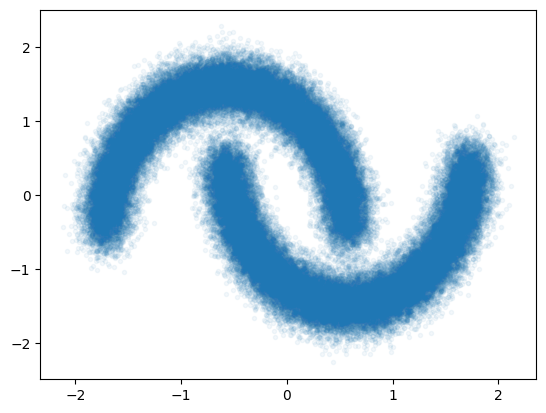

In [26]:
n_samples = 100000
noisy_moons = sklearn.datasets.make_moons(n_samples=n_samples, noise=.1)
noisy_moons[0][:, 0] -= np.mean(noisy_moons[0][:, 0])
noisy_moons[0][:, 0] /= np.std(noisy_moons[0][:, 0])
noisy_moons[0][:, 1] -= np.mean(noisy_moons[0][:, 1])
noisy_moons[0][:, 1] /= np.std(noisy_moons[0][:, 1])
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], '.', alpha=0.05);

**(a) Run the following code to convert the data to a PyTorch dataset:**

In [3]:
moon_dataset = torch.utils.data.TensorDataset(torch.tensor(noisy_moons[0], dtype=torch.float32),
                                              torch.tensor(noisy_moons[1], dtype=torch.float32))

## 9.2 Generator

We define a generator that generates samples from a learned distribution, based on a random noise input.

The generator accepts 1D input vector with 100 elements and has to output a 1D vector with 2 elements.

In [4]:
class MoonGenerator(torch.nn.Module):
    def __init__(self, input_size=100, output_size=2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.net = torch.nn.Sequential(
            torch.nn.Linear(input_size, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, output_size)
        )

    def forward(self, x):
        return self.net(x)

**(a) Generate some samples from this generator before training and plot the resulting distribution.**

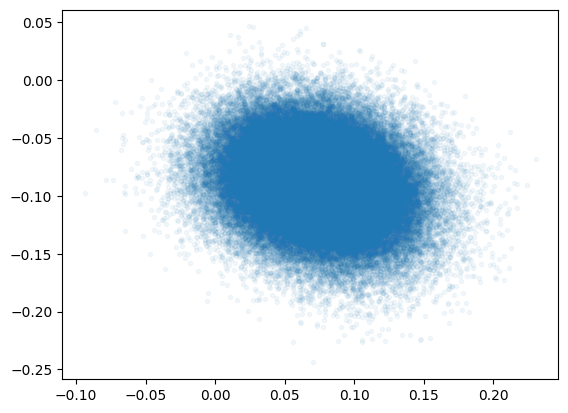

In [5]:
gen = MoonGenerator()
x = torch.rand((n_samples, 100)) * 2 - 1
y = gen(x).detach().cpu().numpy()
plt.plot(y[:, 0], y[:, 1], '.', alpha=0.05);

## 9.3 Untrainable dummy generator network

For our experiments, we also define an untrainable dummy generator network that produces samples from a uniform distribution. We'll use this later to investigate what our discriminator learns.

In [6]:
class UniformMoonGenerator(torch.nn.Module):
    def __init__(self, input_size=100, output_size=2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.dummy_param = torch.nn.Parameter(torch.tensor([0.]))

    def forward(self, x):
        return torch.rand((x.shape[0], self.output_size),
                          device=x.device, dtype=x.dtype) * 4 - 2

**(a) Run the code to generate some samples from this generator and plot the resulting distribution.**

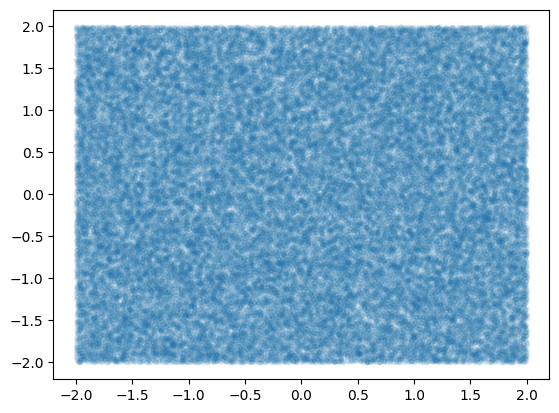

In [7]:
gen = UniformMoonGenerator()
x = torch.randn((n_samples, 100))
y = gen(x).detach().cpu().numpy()
plt.plot(y[:, 0], y[:, 1], '.', alpha=0.05);

## 9.4 Discriminator (1 point)

To train the generator, we need a discriminator that takes the samples from the generator and samples from the real distribution. For real samples, the discriminator should predict 1, for fake samples it should predict 0.

For stability, we will exclude the final sigmoid activation from the discriminator and use the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) function during training.

**(a) Inspect the code for the discriminator below:**

In [8]:
class MoonDiscriminator(torch.nn.Module):
    def __init__(self, inputs=2, hiddens=1024):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(inputs, hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddens, hiddens),
            torch.nn.ReLU(),
            torch.nn.Linear(hiddens, 1)
        )
        # Note: Although this is a binary classifier, we do not yet apply
        #       a sigmoid activation here. Instead, we'll use the
        #       BCEWithLogitsLoss later to compute sigmoid + BCE loss in
        #       a numerically stable way.

    def forward(self, x):
        return self.net(x)

We can plot the value of the discriminator in our sample space to see what it is doing.

**(b) Run the code to plot the output of an untrained discriminator:**

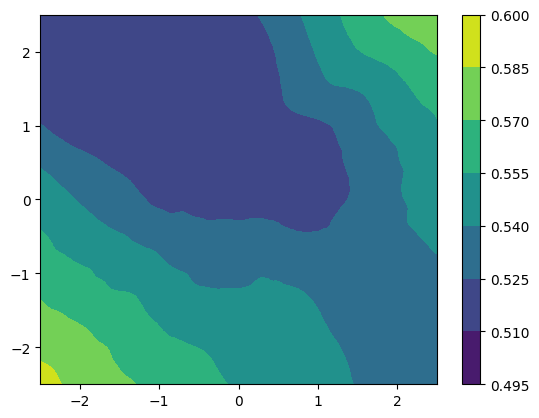

In [33]:
def plot_discriminator(discriminator, xmin=-2.5, xmax=2.5, steps=500, device=device):
    x0, x1 = torch.meshgrid(torch.linspace(xmin, xmax, steps=steps),
                            torch.linspace(xmin, xmax, steps=steps), indexing='ij')
    x = torch.stack([x0.flatten(), x1.flatten()], axis=1).to(device)
    y = discriminator(x)
    y = torch.sigmoid(y).detach().cpu().numpy()
    y = y.reshape(x0.shape)
    plt.contourf(x0, x1, y)
    plt.colorbar()

disc2 = MoonDiscriminator().to(device)
plot_discriminator(disc2)

**(c) How should we expect this plot to look after training the discriminator for the moon dataset?<span style="float:right"> (1 point)</span>**

We expect this plot to look like the moons, with the discriminator predicting 1 inside the moons and 0 outside.

## 9.5 Adversarial training loop (1 point)

Now we have a generator and a discriminator, we can attempt to train the model. We will define a training function that implements the adversarial training procedure:

For each minibatch of real samples:
1. Generate a batch of fake samples;
2. Compute the discriminator loss on the real and fake samples;
3. Optimize the discriminator;
4. Generate another batch of fake samples;
5. Compute the generator loss on the fake samples;
6. Update the generator.

To monitor training, we'll print the discriminator and generator loss. We'll also monitor the accuracy of the discriminator (the percentage of correctly labeled real and fake samples) and the 'accuracy' of the generator (the percentage of fake samples incorrectly labeled as real by the discriminator).

**(a) Complete the training loop below:<span style="float:right"> (1 point)</span>**

In [41]:
def train_adversarial(generator, discriminator, data_loader, epochs=10,
                      lr_gen=0.001, lr_disc=0.001, device=device):
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr_gen)
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr_disc)

    bce_logits_loss = torch.nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        epoch_disc_loss = 0
        epoch_gen_loss = 0
        epoch_disc_acc = 0
        epoch_gen_acc = 0
        mb_count = 0

        for x_real, _ in data_loader:
            x_real = x_real.to(device)

            ## 1. Discriminator
            # generate noise for the generator
            rand_for_gen = torch.rand((x_real.shape[0], generator.input_size),
                                      device=x_real.device, dtype=x_real.dtype) * 2 - 1
            # generate fake samples
            x_fake = generator(rand_for_gen)

            # run discriminator on real and fake samples
            d_real = discriminator(x_real)
            d_fake = discriminator(x_fake)

            # compute discriminator loss
            # - for real samples, the discriminator should predict 1
            # - for fake samples, the discriminator should predict 0
            disc_loss = (bce_logits_loss(d_real, torch.ones_like(d_real)) +
                         bce_logits_loss(d_fake, torch.zeros_like(d_fake)))
            disc_acc = (torch.mean((d_real > 0).to(torch.float)) +
                        torch.mean((d_fake < 0).to(torch.float))) / 2

            # update discriminator
            disc_optimizer.zero_grad()
            disc_loss.backward()
            disc_optimizer.step()


            ## 2. Generator
            # generate another batch of fake samples
            rand_for_gen = torch.rand((x_real.shape[0], generator.input_size),
                                      device=x_real.device, dtype=x_real.dtype) * 2 - 1
            x_fake = generator(rand_for_gen)

            # compute generator loss
            d_fake = discriminator(x_fake)
            # TODO: compute the generator loss using d_fake and bce_logits_loss
            #       and the appropriate target value (see the implementation for
            #       the discriminator loss)
            gen_loss = bce_logits_loss(d_fake, torch.ones_like(d_fake))
            # for the generator, we compute how many generated samples were given
            # the label 'real' by the discriminator
            gen_acc = torch.mean((d_fake > 0).to(torch.float))

            # update generator
            gen_optimizer.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

            ## 3. Statistics
            epoch_disc_loss += disc_loss.item()
            epoch_gen_loss += gen_loss.item()
            epoch_disc_acc += disc_acc.item()
            epoch_gen_acc += gen_acc.item()
            mb_count += 1

        print('Epoch %d: disc_loss=%f gen_loss=%f  disc_acc=%f gen_acc=%f' %
              (epoch, epoch_disc_loss / mb_count, epoch_gen_loss / mb_count,
               epoch_disc_acc / mb_count, epoch_gen_acc / mb_count))

## 9.6 Experiment: Train the discriminator only (1 point)

First, we'll train the discriminator only, using the dummy generator to generate samples from a uniform distribution.

**(a) Run the code to train the discriminator:**

In [44]:
gen1 = UniformMoonGenerator().to(device)
disc1 = MoonDiscriminator().to(device)

loader = torch.utils.data.DataLoader(moon_dataset, batch_size=128)
train_adversarial(gen1, disc1, loader, epochs=10, lr_gen=0.001, lr_disc=0.001, device=device)

Epoch 0: disc_loss=0.972028 gen_loss=3.049695  disc_acc=0.759761 gen_acc=0.346957
Epoch 1: disc_loss=0.897476 gen_loss=3.622413  disc_acc=0.789377 gen_acc=0.307715
Epoch 2: disc_loss=0.891329 gen_loss=3.742611  disc_acc=0.791150 gen_acc=0.309163
Epoch 3: disc_loss=0.888391 gen_loss=3.820148  disc_acc=0.791515 gen_acc=0.311001
Epoch 4: disc_loss=0.885106 gen_loss=3.865941  disc_acc=0.791890 gen_acc=0.308474
Epoch 5: disc_loss=0.886932 gen_loss=3.898879  disc_acc=0.791740 gen_acc=0.310382
Epoch 6: disc_loss=0.885936 gen_loss=3.910922  disc_acc=0.791910 gen_acc=0.310981
Epoch 7: disc_loss=0.886855 gen_loss=3.946088  disc_acc=0.791430 gen_acc=0.309253
Epoch 8: disc_loss=0.885765 gen_loss=3.943249  disc_acc=0.791925 gen_acc=0.304797
Epoch 9: disc_loss=0.882792 gen_loss=3.963360  disc_acc=0.792854 gen_acc=0.308903


**(b) Plot the discriminator output and inspect the result.**

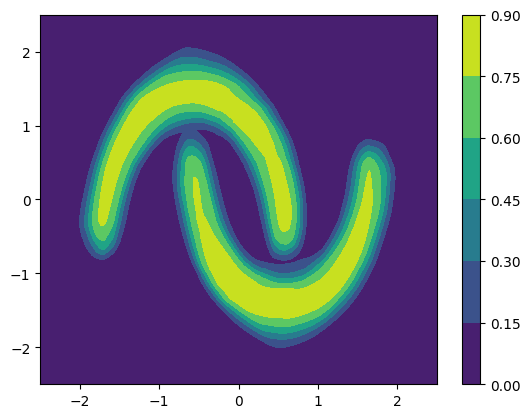

In [45]:
plot_discriminator(disc1)

**(c) Why does the discriminator not predict 1.00 inside the moons?<span style="float:right"> (1 point)</span>**

The discriminator is not able to predict with 100% accuracy because the generator is adding, during the train, some noise that reduce the precision of the discriminator.
#TODO: not sure, check that

## 9.7 Experiment: Train the generator and discriminator (8 points)

We'll now train the model with the trainable generator.

**(a) Train the generator and discriminator together:**

In [46]:
gen2 = MoonGenerator().to(device)
disc2 = MoonDiscriminator().to(device)

loader = torch.utils.data.DataLoader(moon_dataset, batch_size=128)
train_adversarial(gen2, disc2, loader, epochs=10, lr_gen=0.001, lr_disc=0.001, device=device)

Epoch 0: disc_loss=0.939841 gen_loss=1.536817  disc_acc=0.763337 gen_acc=0.201217
Epoch 1: disc_loss=1.189688 gen_loss=0.985395  disc_acc=0.650286 gen_acc=0.260730
Epoch 2: disc_loss=1.293903 gen_loss=0.842235  disc_acc=0.600528 gen_acc=0.320752
Epoch 3: disc_loss=1.353198 gen_loss=0.764618  disc_acc=0.562870 gen_acc=0.372872
Epoch 4: disc_loss=1.364797 gen_loss=0.752113  disc_acc=0.550102 gen_acc=0.357517
Epoch 5: disc_loss=1.384413 gen_loss=0.702178  disc_acc=0.513757 gen_acc=0.455243
Epoch 6: disc_loss=1.322143 gen_loss=0.866896  disc_acc=0.583984 gen_acc=0.362792
Epoch 7: disc_loss=1.386694 gen_loss=0.704398  disc_acc=0.507448 gen_acc=0.461837
Epoch 8: disc_loss=1.388199 gen_loss=0.697141  disc_acc=0.501374 gen_acc=0.487312
Epoch 9: disc_loss=1.387690 gen_loss=0.698341  disc_acc=0.504121 gen_acc=0.483056


**(b) Run the code below to plot the generated samples, the discriminator output, and the real samples.**

**Note:** If you don't get a good results, try to run the model again. This model is quite sensitive to the random initialisation.

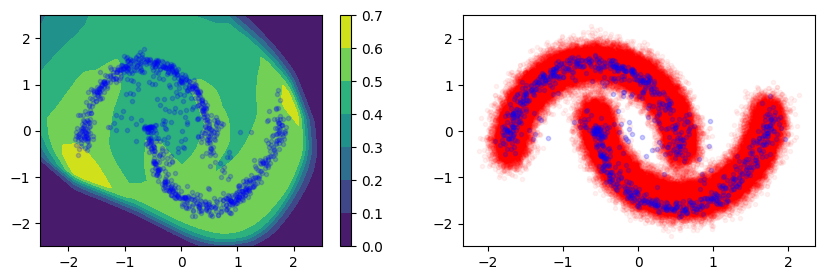

In [47]:
def plot_generator(generator, n_samples=1000, device=device):
    x = torch.rand((n_samples, 100)).to(device) * 2 - 1
    y = generator(x).detach().cpu().numpy()
    plt.plot(y[:, 0], y[:, 1], 'b.', alpha=0.2)

plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plot_discriminator(disc2)
plot_generator(gen2)
plt.subplot(1, 2, 2)
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], 'r.', alpha=0.05)
plot_generator(gen2)

**(c) Briefly discuss this result.<span style="float:right"> (1 point)</span>**

As we can see, the generator's loss and the discriminator's loss are converged to a similar value. So the generator now is able to create more realistic instances.
In the figures we can see that the generated instances are similar to the real one, so the discriminator is less able to distinguish them

Compare the output of the new discriminator with the output of the discriminator trained without a generator.

**(d) Are the discriminator outputs the same? Explain why this happens.<span style="float:right"> (1 point)</span>**

The output of the two discriminators are different, the first one was able to detect with more precision the areas of the moons, while the second one has worse precision. This happen because the generator is able to mimic better the real distribution, so the task of the discriminator is harder.

**(e) Does the discriminator still reach a high accuracy? Why (not?)<span style="float:right"> (1 point)</span>**

No, the discriminator reach a poor accuracy (~0.5). Because the fake instances are more similar to the real ones, so the task is harder.

**(f) How can we see if the model is working well based on the discriminator accuracy?<span style="float:right"> (2 points)</span>**

Based on the accuracy of the discriminator we can understand the abilities of the generator and discriminator: if is close to 1, the generator is not able to generate realistic instances; if is close to 0 the discriminator is missclassifying most of the sample, so there are some problems with the discriminator or the generator is too good; if is close to 0.5 the discriminator is not better than random chance, so generator is able to generate realistic instances.

**(g) Compare the distribution learned by the generator with the real distribution. What are the main differences?<span style="float:right"> (1 point)</span>**

The two distributions are similar but some differences along the edges. The fake moons are thinner and shortier (the didn't reach properly the ends)

**(h) Explain the differences you observed above: Why are the generated and real distributions different?<span style="float:right"> (1 point)</span>**

The cause of those differences could be that there are less real sample with point in that positions (because that depends on the noise of the real data); so the generator is less able to mimic those particular instances.

**(i) How can you make the distributions more similar?<span style="float:right"> (1 point)</span>**

We could make the distributions more similar by increasing the epochs or the model complexity.

## 9.8 Gradient reversal (5 point)

As an alternative to training the discriminator and generator separately, we can also train the model with a gradient reversal layer that reverses the gradient coming from the discriminator:

```
Forward: generator -> discriminator.
Backward: generator gradient <- gradient reversal <- discriminator gradient.
```

In PyTorch, we'll implement this as a function `revgrad(x)` that will reverse the gradient that passes through it. You can use it like this:
```
y = discriminator(revgrad(generator(x)))
loss = loss_fn(y, target)
loss.backward()
```

**(a) Complete the code to define the `revgrad` gradient reversal function:<span style="float:right"> (1 point)</span>**

In [48]:
class RevGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        output = input
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # TODO: Compute the reverse of the gradient
        grad_input = -grad_output
        return grad_input

revgrad = RevGrad.apply

The training loop is now a bit simpler than before, because we do not have to compute the generator loss separately.

**(b) Complete the new training function:<span style="float:right"> (1 point)</span>**

In [49]:
def train_adversarial_revgrad(generator, discriminator, data_loader, epochs=10, lr=0.001, device=device):
    parameters = list(generator.parameters()) + list(discriminator.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)

    bce_logits_loss = torch.nn.BCEWithLogitsLoss()
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_acc_real = 0
        epoch_acc_fake = 0
        mb_count = 0

        for x_real, _ in data_loader:
            x_real = x_real.to(device)

            # generate fake samples
            rand_for_gen = torch.rand((x_real.shape[0], generator.input_size),
                                      device=x_real.device, dtype=x_real.dtype) * 2 - 1
            x_fake = generator(rand_for_gen)

            # run discriminator on real and random samples,
            # reverse the gradient for the generator
            d_real = discriminator(x_real)
            # TODO: compute the discriminator output like before,
            #       but include the gradient reversal layer
            d_fake = discriminator(revgrad(x_fake))

            # compute loss
            loss_real = bce_logits_loss(d_real, torch.ones_like(d_real))
            loss_fake = bce_logits_loss(d_fake, torch.zeros_like(d_fake))
            loss = loss_real + loss_fake
            
            # compute discriminator accuracy
            acc_real = torch.mean((d_real > 0).to(torch.float))
            acc_fake = torch.mean((d_fake < 0).to(torch.float))

            # update generator and discriminator
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update statistics
            epoch_loss += loss.item()
            epoch_acc_real += acc_real.item()
            epoch_acc_fake += acc_fake.item()
            mb_count += 1

        print('Epoch %d: loss=%f  acc_real=%f acc_fake=%f' %
              (epoch, epoch_loss / mb_count,
               epoch_acc_real / mb_count, epoch_acc_fake / mb_count))

**(c) Train a generator and discriminator with the new training function:**

In [50]:
gen3 = MoonGenerator().to(device)
disc3 = MoonDiscriminator().to(device)

loader = torch.utils.data.DataLoader(moon_dataset, batch_size=128)
train_adversarial_revgrad(gen3, disc3, loader, epochs=10, lr=0.001, device=device)

Epoch 0: loss=1.057800  acc_real=0.756694 acc_fake=0.702685
Epoch 1: loss=1.211779  acc_real=0.672075 acc_fake=0.628097
Epoch 2: loss=1.334141  acc_real=0.588035 acc_fake=0.550452
Epoch 3: loss=1.375175  acc_real=0.553129 acc_fake=0.500490
Epoch 4: loss=1.372888  acc_real=0.567445 acc_fake=0.492148
Epoch 5: loss=1.378217  acc_real=0.534637 acc_fake=0.526045
Epoch 6: loss=1.385080  acc_real=0.523997 acc_fake=0.501069
Epoch 7: loss=1.367078  acc_real=0.541640 acc_fake=0.548164
Epoch 8: loss=1.358536  acc_real=0.566826 acc_fake=0.513267
Epoch 9: loss=1.385974  acc_real=0.542709 acc_fake=0.476233


**(d) Plot and inspect the results:**

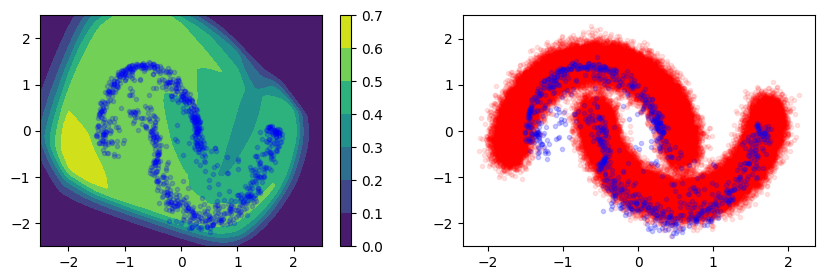

In [52]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
plot_discriminator(disc3)
plot_generator(gen3)

plt.subplot(1, 2, 2)
plt.plot(noisy_moons[0][:, 0], noisy_moons[0][:, 1], 'r.', alpha=0.1)
plot_generator(gen3)

**(e) Briefly discuss the result.<span style="float:right"> (1 point)</span>**

As we can see from the figures, the results are similar. But in this case the generator is a bit less precise at generating fake samples.

**(f) What are some advantages and disadvantages of the gradient reversal layer, compared with the previous two-step approach?<span style="float:right"> (2 points)</span>**

The main advantage of this method is that we don't need to train the generator and the discriminator separately, so we can save some time. The main disadvantage is that the generator is less precise at generating fake samples.

## 9.9 Emoji dataset

For the second part of this assignment we will borrow an emoji dataset (and some ideas) from a course at the [University of Toronto](http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/).

The dataset contains images of Apple-style and Windows-style emojis. You can [download the files](http://www.cs.toronto.edu/~jba/emojis.tar.gz) yourself or use the code below.

**(a) Download the dataset and extract the files:**

In [53]:
# !wget -c http://www.cs.toronto.edu/~jba/emojis.tar.gz
# !tar xzf emojis.tar.gz

We'll resize the images to 32 by 32 pixels and normalize the RGB intensities to values between -1 and 1.

**(b) Run the code to construct the datasets:**

In [64]:
def image_loader(path):
    with open(path, 'rb') as f:
        img = PIL.Image.open(f)
        return img.convert('RGBA').convert('RGB')

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32, 32)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

d_windows = torchvision.datasets.ImageFolder('emojis/Windows/', transform, loader=image_loader)
d_apple = torchvision.datasets.ImageFolder('emojis/Apple/', transform, loader=image_loader)

**(c) Plot a few images to see the different styles:**

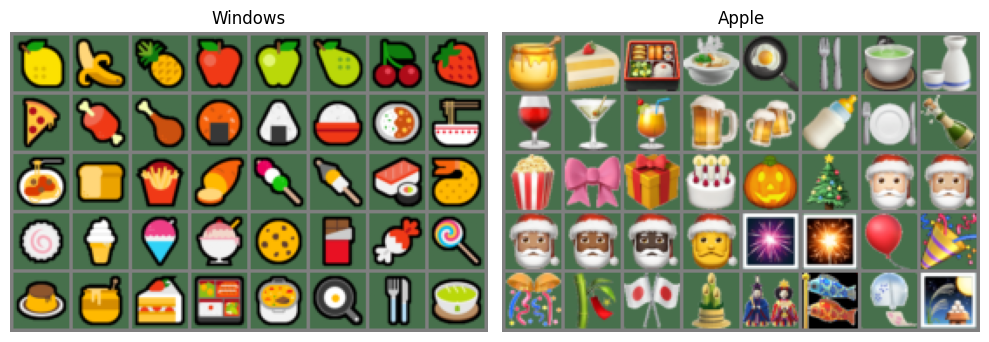

In [65]:
def image_grid(d, idxs):
    images = [d[idx][0] for idx in idxs]
    grid = torchvision.utils.make_grid(images)
    return grid.numpy().transpose(1, 2, 0) / 2 + 0.5

# Depending on the PyTorch version, this code might print
# a warning about transparency. This is not a problem.

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image_grid(d_windows, range(100, 140)))
plt.title('Windows')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image_grid(d_apple, range(400, 440)))
plt.title('Apple')
plt.axis('off')
plt.tight_layout()

## 9.10 CycleGAN (2 points)

We'll try to train a CycleGAN that can translate emojis between the Windows and Apple styles.

This CycleGAN has the following components:
* A generator that translates from Windows to Apple;
* A generator that translates from Apple to Windows;
* A discriminator that discriminates between real and fake emojis from the Windows distribution;
* A discriminator that discriminates between real and fake emojis from the Apple distribution.

### Generator

First, we define the generator. We'll use the same generator architecture for both directions. Unlike before, the generator does not take random noise as input, but expects a 32 by 32 RGB image as input and returns a 32 by 32 RGB image as output.

The generator has the following structure:
```
- Input: 32x32 pixels, 3 channels.
- Two downsampling + convolution blocks:
  kernel size = (5, 5), stride = 2, padding = ?,
  from 3 -> 32 -> 64 channels.
- One convolution block in the middle:
  kernel size = (5, 5), stride = 1, padding = ?,
  from 64 -> 64 channels.
- Two upsampling + convolution blocks:
  upsampling (scale factor 2) followed by convolution,
  kernel size = (5, 5), stride = 1, padding = ?,
  from 64 -> 32 -> 3 channels.
- Output: 32x32 pixels, 3 channels.
```

Add batch normalization and ReLU activations after each convolution, except after the very last layer.

The images have a [-1, +1] range, so the last output should use a tanh activation without BN.

**(a) Complete the code below:<span style="float:right"> (2 points)</span>**

In [66]:
class CycleGenerator(torch.nn.Module):
    def __init__(self, input_size=100):
        super().__init__()
        self.input_size = input_size
        self.net = torch.nn.Sequential(
            # downsampling 32 -> 16 -> 8 pixels
            # TODO: implement the downsampling part as described above
            torch.nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=2),
            torch.nn.BatchNorm2d(32), torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2),
            torch.nn.BatchNorm2d(64), torch.nn.ReLU(),
            # no downsampling, no upsampling
            torch.nn.Conv2d(64, 64, (5, 5), padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            # upsampling 8 -> 16 -> 32 pixels
            # TODO: complete the upsampling part as described above
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(64, 32, (5, 5), stride=1, padding=2),
            torch.nn.BatchNorm2d(32), torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(32, 3, (5, 5), stride=1, padding=2),
            torch.nn.Tanh(),
        )

    def forward(self, x):
        return self.net(x)

# the output should have the same shape as the input
assert CycleGenerator()(torch.zeros((30, 3, 32, 32))).shape == torch.Size([30, 3, 32, 32]), "the output should have the same shape as the input"
assert torch.min(CycleGenerator()(torch.zeros((30, 3, 32, 32)))) > -1, "outputs should be in the range [-1,1]"
assert torch.max(CycleGenerator()(torch.zeros((30, 3, 32, 32)))) < 1,  "outputs should be in the range [-1,1]"

### Discriminator

The discriminator is similar in concept to what we had in the GAN model: it takes an image and predicts 1 for a real image and 0 for a fake.

```
- Input: 32x32 pixels, 3 channels.
- Three downsampling + convolution blocks:
  kernel size = (5, 5), stride = 2, padding = ?,
  from 3 -> 64 -> 64 -> 64 channels.
- One fully connected layer from (64*4*4) to 1.
- Output: 1 output element.
```

Add batch normalization and ReLU after each convolution, except at the end of the network.

**(b) Read through the code below:**

In [67]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            # downsampling 32 -> 16 -> 8 -> 4
            torch.nn.Conv2d(3, 64, (5, 5), stride=2, padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(64, 64, (5, 5), stride=2, padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(64, 64, (5, 5), stride=2, padding=2, bias=False),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Flatten(),
            
            torch.nn.Linear(64 * 4 * 4, 1)
        )
        # Note: Although this is a binary classifier, we do not apply
        #       a sigmoid activation here. We'll optimize a mean-squared
        #       error to make the discriminator's task a bit harder and
        #       get a slightly better gradient.

    def forward(self, x):
        return self.net(x)

# the output shape should be (30, 1)
assert Discriminator()(torch.zeros((30, 3, 32, 32))).shape == torch.Size([30, 1]), "the output should have shape [30,1]"

## 9.11 CycleGAN training loop (2 points)

The training loop for the GAN with cycle-consistency loss follows the following procedure:

For each batch of samples from domain A and B:
* Use the generators to predict the fake B given A, and fake A given B.
* Use the generators to reconstruct A given fake B, and B given fake A.

The discriminator loss is composed of:
* The discriminator losses for real samples from A and B.
* The discriminator losses for fake samples from A and B.

The cycle-consistency loss is composed of:
* The reconstruction loss comparing the real A with the cycled A->B->A.
* The reconstruction loss comparing the real B with the cycled B->A->B.

Finally, the two groups losses are combined with a weight `lambda_cycle` for the cycle-consistency loss:

```loss = discriminator_loss + lambda_cycle * cycle-consistency loss```

**(a) Complete the code below to implement this procedure:<span style="float:right"> (2 points)</span>**

In [68]:
def train_cycle(generator_ab, generator_ba, discriminator_a, discriminator_b,
                data_loader_a, data_loader_b,
                epochs=10, lr=0.001, lambda_cycle=0.1, device=device):
    mse_loss = torch.nn.MSELoss()
    models = torch.nn.ModuleList([generator_ab, generator_ba, discriminator_a, discriminator_b])
    optimizer = torch.optim.Adam(models.parameters(), lr=lr, betas=(0.5, 0.999))
    
    plt.figure(figsize=(10, 15))

    for epoch in range(epochs):
        epoch_stats = defaultdict(lambda: 0)
        mb_count = 0

        disc_a.train()
        disc_b.train()
        gen_ab.train()
        gen_ba.train()

        for (real_a, _), (real_b, _) in zip(loader_a, loader_b):
            real_a = real_a.to(device)
            real_b = real_b.to(device)

            # compute fake images A->B->A
            fake_ab = generator_ab(real_a)
            cycle_aba = generator_ba(fake_ab)

            # compute fake images B->A->B
            fake_ba = generator_ba(real_b)
            cycle_bab = generator_ab(fake_ba)

            # run discriminator on real and fake images
            d_real_a = discriminator_a(real_a)
            # TODO: compute other discriminator output, use gradient reversal where necessary
            d_real_b = discriminator_b(real_b)  # TODO
            d_fake_ba = discriminator_a(revgrad(cycle_aba))  # TODO
            d_fake_ab = discriminator_b(revgrad(cycle_bab))  # TODO

            # compute discriminator loss
            # we optimize the MSE loss function to make the gradients of
            # the discriminator a bit easier to use
            loss_real_a = mse_loss(d_real_a, torch.ones_like(d_real_a))
            loss_real_b = mse_loss(d_real_b, torch.ones_like(d_real_b))  # TODO
            loss_fake_a = mse_loss(d_fake_ba, torch.zeros_like(d_fake_ba))  # TODO
            loss_fake_b = mse_loss(d_fake_ab, torch.zeros_like(d_fake_ab))  # TODO

            # compute cycle-consistency loss
            loss_cycle_a = mse_loss(cycle_aba, real_a)
            loss_cycle_b = mse_loss(cycle_bab, real_b)

            # compute loss
            loss = loss_real_a + loss_real_b + \
                   loss_fake_a + loss_fake_b + \
                   lambda_cycle * (loss_cycle_a + loss_cycle_b)

            # optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update statistics
            epoch_stats['loss'] += loss.item()
            epoch_stats['loss_real_a'] += loss_real_a.item()
            epoch_stats['loss_real_b'] += loss_real_b.item()
            epoch_stats['loss_fake_a'] += loss_fake_a.item()
            epoch_stats['loss_fake_b'] += loss_fake_b.item()
            epoch_stats['loss_cycle_a'] += loss_cycle_a.item()
            epoch_stats['loss_cycle_b'] += loss_cycle_b.item()
            mb_count += 1

        if epoch % 5 == 0:
            print('Epoch %d: ' % epoch, end='')
            for k, v in epoch_stats.items():
                print(' %s=%6.4f' % (k, v / mb_count), end='')

            images_for_plot = {
                'real_a': real_a, 'fake_ab': fake_ab, 'cycle_aba': cycle_aba,
                'real_b': real_b, 'fake_ba': fake_ba, 'cycle_bab': cycle_bab,
            }

            for k in range(10):
                for i, (im_title, im) in enumerate(images_for_plot.items()):
                    plt.subplot(10, 6, k * 6 + i + 1)
                    plt.imshow(im[k].detach().cpu().numpy().transpose(1, 2, 0) / 2 + 0.5)
                    if k == 0:
                        plt.title(im_title)
                    plt.axis('off')
            plt.tight_layout()
            display.display(plt.gcf())
            display.clear_output(wait=True)


## 9.12 Experiment: CycleGAN training (6 points)

We can now train our CycleGAN model.

**(a) Run the code below and play with the hyperparameters if necessary to learn a reasonable output.**

Note that GANs can be notoriously difficult to train, so don't worry if your results are not perfect. Hopefully, you will be able to get somewhat recognizable results, but it's more important that you can interpret and discuss what happens.

In [ ]:
gen_ab = CycleGenerator().to(device)
gen_ba = CycleGenerator().to(device)
disc_a = Discriminator().to(device)
disc_b = Discriminator().to(device)

loader_a = torch.utils.data.DataLoader(d_windows, batch_size=32, shuffle=True, num_workers=4)
loader_b = torch.utils.data.DataLoader(d_apple, batch_size=32, shuffle=True, num_workers=4)

train_cycle(gen_ab, gen_ba, disc_a, disc_b, loader_a, loader_b,
            epochs=100, lr=0.001, lambda_cycle=1, device=device)

**(b) Discuss your results and training experience. Was the model easy to train? What do you think of the results? Does it learn a good translation between Windows and Apple emojis?<span style="float:right"> (2 points)</span>**

TODO: Your answer here.

**(c) Run some more experiments to study the effect of the `lambda_cycle` weight.<span style="float:right"> (1 point)</span>**

In [ ]:
# TODO: Your experiments here.

**(d) What is the effect of the `lambda_cycle` weight? What happens if you set it to a much larger value? What happens if you set it to 0? Can you explain this?<span style="float:right"> (2 points)</span>**

TODO: Your answer here.

**(e) Why is the reconstructed output (A->B->A or B->A->B) usually better than the translated output (A->B or B->A)?<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

## 9.13 Final questions (4 points)

**(a) Discuss how the balance between the generator and discriminator affects GAN training. What can go wrong if one part is better or learns more quickly than the other?<span style="float:right"> (2 points)</span>**

TODO: Your answer here.

**(b) CycleGAN and similar methods are unsupervised models that learn to map inputs from one domain to another. Does this mapping necessarily preserve the semantics of the images? Why, or why not?<span style="float:right"> (1 point)</span>**
<br>(For example, think about how our emoji model would translate flags.)

TODO: Your answer here.

**(c) Have a brief look at [CycleGAN, a Master of Steganography](https://arxiv.org/pdf/1712.02950.pdf), a paper published at NIPS 2017. The authors show that a CycleGAN network sometimes 'hides' information in the generated images, to help with the reconstruction. Can you see something like this in your results as well?<span style="float:right"> (1 point)</span>**

TODO: Your answer here.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 30 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version d7aee7b / 2023-11-09</span>